In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Download the dataset as a zip file
!kaggle datasets download -d ankit1743/skyview-an-aerial-landscape-dataset

Dataset URL: https://www.kaggle.com/datasets/ankit1743/skyview-an-aerial-landscape-dataset
License(s): CC0-1.0
 97% 150M/154M [00:01<00:00, 160MB/s]
100% 154M/154M [00:01<00:00, 135MB/s]


In [3]:
# Unzip the data
!unzip /content/skyview-an-aerial-landscape-dataset.zip

Strømmer utdata som er avkortet til de siste 5000 linjene.
  inflating: Aerial_Landscapes/Lake/601.jpg  
  inflating: Aerial_Landscapes/Lake/602.jpg  
  inflating: Aerial_Landscapes/Lake/603.jpg  
  inflating: Aerial_Landscapes/Lake/604.jpg  
  inflating: Aerial_Landscapes/Lake/605.jpg  
  inflating: Aerial_Landscapes/Lake/606.jpg  
  inflating: Aerial_Landscapes/Lake/607.jpg  
  inflating: Aerial_Landscapes/Lake/608.jpg  
  inflating: Aerial_Landscapes/Lake/609.jpg  
  inflating: Aerial_Landscapes/Lake/610.jpg  
  inflating: Aerial_Landscapes/Lake/611.jpg  
  inflating: Aerial_Landscapes/Lake/612.jpg  
  inflating: Aerial_Landscapes/Lake/613.jpg  
  inflating: Aerial_Landscapes/Lake/614.jpg  
  inflating: Aerial_Landscapes/Lake/615.jpg  
  inflating: Aerial_Landscapes/Lake/616.jpg  
  inflating: Aerial_Landscapes/Lake/617.jpg  
  inflating: Aerial_Landscapes/Lake/618.jpg  
  inflating: Aerial_Landscapes/Lake/619.jpg  
  inflating: Aerial_Landscapes/Lake/620.jpg  
  inflating: Aerial_L

In [4]:
import os

# Define the dataset path
dataset_path = '/content/Aerial_Landscapes'

# Get the folder names as labels
labels = os.listdir(dataset_path)
print('Labels:', labels)
print(f'No of Classes = {len(labels)}')

Labels: ['Port', 'Agriculture', 'Highway', 'Grassland', 'Desert', 'River', 'Beach', 'Residential', 'Railway', 'Mountain', 'Parking', 'City', 'Forest', 'Lake', 'Airport']
No of Classes = 15


In [5]:
image_paths = []
image_labels = []

# Traverse the dataset directory
for label in labels:
    folder_path = os.path.join(dataset_path, label)

    # Get all image files in the folder
    for img_file in os.listdir(folder_path):
        image_paths.append(os.path.join(folder_path, img_file))
        image_labels.append(label)

# Print the first few paths and labels
for path, label in zip(image_paths[:10], image_labels[:10]):
    print(f'Image Path: {path} | Label: {label}')


Image Path: /content/Aerial_Landscapes/Port/143.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/284.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/426.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/367.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/190.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/672.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/194.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/576.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/110.jpg | Label: Port
Image Path: /content/Aerial_Landscapes/Port/490.jpg | Label: Port


In [6]:
import os
from sklearn.model_selection import train_test_split

# Prepare the list of image paths and their corresponding labels
image_paths = []
image_labels = []

for label in labels:
    folder_path = os.path.join(dataset_path, label)

    # Get all image files in the folder
    for img_file in os.listdir(folder_path):
        image_paths.append(os.path.join(folder_path, img_file))
        image_labels.append(label)



# Split into train and temp (validation + test) sets
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.3, stratify=image_labels, random_state=42)

# Split temp into validation and test sets
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Print the sizes of each set
print(f'Training set size: {len(train_paths)}')
print(f'Validation set size: {len(val_paths)}')
print(f'Test set size: {len(test_paths)}')
# 70% training, 15% validation, and 15% test data.

Training set size: 8400
Validation set size: 1800
Test set size: 1800


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

# Custom Dataset Class for our project or task
class ImageDataset(Dataset):
    # Initialize the dataset with image paths, labels, and optional transformations
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.label_mapping = {label: idx for idx, label in enumerate(set(image_labels))}
        self.image_labels = [self.label_mapping[label] for label in image_labels]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert('RGB')

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Get label
        label = self.image_labels[idx]

        label = torch.tensor(label, dtype=torch.long)

        return image, label


In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),        
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize with standard mean and std
])

In [ ]:
#Cutout Function

import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

class Cutout(object):
    def __init__(self, mask_size, p=0.5):
        self.mask_size = mask_size
        self.p = p

    def __call__(self, img):
        if np.random.rand() > self.p:
            return img
        h, w = img.size[1], img.size[0]
        mask_size_half = self.mask_size // 2
        cx, cy = np.random.randint(0, w), np.random.randint(0, h)
        x1, x2 = np.clip([cx - mask_size_half, cx + mask_size_half], 0, w)
        y1, y2 = np.clip([cy - mask_size_half, cy + mask_size_half], 0, h)
        img_np = np.array(img)
        img_np[y1:y2, x1:x2] = 0
        return Image.fromarray(img_np)



In [ ]:
#Train and val-transforms
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


train_transforms = transforms.Compose([
    #transforms.RandomResizecrop(224),      # Random crop to 224x224
    transforms.RandomHorizontalFlip(),      # Random horizontal flipping
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.2)), # Random zoom
    #transforms.RandomRotation(15), # Random rotation up to 15 degrees
    Cutout(mask_size=50, p=0.50),
    #transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),  # Random color changes
    transforms.ToTensor(),                  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard values from imagenet
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),                 
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),                 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])


In [17]:
# Create datasets
train_dataset = ImageDataset(train_paths, train_labels, transform=train_transforms)
val_dataset = ImageDataset(val_paths, val_labels, transform=val_transforms)
test_dataset = ImageDataset(test_paths, test_labels, transform=transform)

In [18]:
# Hyperparameters
batch_size = 32
num_workers = 2  # Adjust based on your system's capabilities (only if we have a GPU)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
#EarlyStopping

class EarlyStopping:
   
    def __init__(self, patience, delta):
        self.patience = patience
        self.delta = delta
        self.best_score = None  # Tracks the best loss (lower is better)
        self.early_stop = False  # Flag for early stopping
        self.counter = 0  # Counter for epochs without improvement
        self.best_loss = np.Inf  # Best loss starts as infinity

    def __call__(self, val_loss, model, idx):
        
        score = -val_loss  # Loss is used as the score (lower is better, so we negate it)

        # If this is the first epoch or loss improved significantly
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, idx)
        elif score < self.best_score - self.delta:
            # No significant improvement (i..e, loss hasn't decreased enough)
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # Improvement in loss
            self.best_score = score
            self.save_checkpoint(val_loss, model, idx)
            self.counter = 0  # Reset the counter if loss improves

    def save_checkpoint(self, val_loss, model, idx):
        
        if val_loss < self.best_loss:  # We save if loss decreased
            self.best_loss = val_loss
            checkpoint_name = idx
            torch.save(model.state_dict(), checkpoint_name)
            print(f'Model saved as {checkpoint_name}')

In [ ]:
import torch
from torchvision.models import vgg16, resnet50, efficientnet_b0, VGG16_Weights, ResNet50_Weights, EfficientNet_B0_Weights
import torch.optim as optim
import torch.nn as nn




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = ['ResNet_checkpoint.pth', 'VGG16_checkpoint.pth', 'Efficientnet_B0.pth']
# Initialize models
models = [resnet50(weights=ResNet50_Weights.DEFAULT), vgg16(weights=VGG16_Weights.DEFAULT), efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)]


num_labels = len(train_dataset.image_labels)  
models[0].fc = nn.Linear(models[0].fc.in_features, num_labels)
models[1].classifier[6] = nn.Linear(models[1].classifier[6].in_features, num_labels)
models[2].classifier[1] = nn.Linear(models[2].classifier[1].in_features, num_labels)


train_losses = [[],[],[]]
val_losses = [[],[],[]]
train_accuracies = [[],[],[]]
val_accuracies = [[],[],[]]

num_epochs = 30

for i, model in enumerate(models):
      model = models[i]
      model = model.to(device)
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
      early_stopping = EarlyStopping(patience=9, delta=0.0005)

      for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_losses[i].append(train_loss)
        train_accuracy = 100 * correct / total
        train_accuracies[i].append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_losses[i].append(val_loss)
        val_accuracy = 100 * correct / total
        val_accuracies[i].append(val_accuracy)

        print(f'Model {i+1} - Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        early_stopping(val_loss, model, checkpoint[i])

        if early_stopping.early_stop:
          print("Early stopping")
          break

Model 1 - Epoch 1/30, Train Loss: 0.9143, Train Accuracy: 77.08%, Val Loss: 1.7095, Val Accuracy: 67.50%
Model saved as ResNet_checkpoint.pth
Model 1 - Epoch 2/30, Train Loss: 0.4398, Train Accuracy: 86.79%, Val Loss: 1.8472, Val Accuracy: 71.22%
EarlyStopping counter: 1 out of 9
Model 1 - Epoch 3/30, Train Loss: 0.3838, Train Accuracy: 88.54%, Val Loss: 2.1151, Val Accuracy: 71.44%
EarlyStopping counter: 2 out of 9
Model 1 - Epoch 4/30, Train Loss: 0.3690, Train Accuracy: 88.69%, Val Loss: 1.7971, Val Accuracy: 75.00%
EarlyStopping counter: 3 out of 9
Model 1 - Epoch 5/30, Train Loss: 0.3494, Train Accuracy: 88.89%, Val Loss: 1.6601, Val Accuracy: 73.28%
Model saved as ResNet_checkpoint.pth
Model 1 - Epoch 6/30, Train Loss: 0.3504, Train Accuracy: 89.54%, Val Loss: 2.0686, Val Accuracy: 70.28%
EarlyStopping counter: 1 out of 9
Model 1 - Epoch 7/30, Train Loss: 0.3529, Train Accuracy: 88.74%, Val Loss: 1.7885, Val Accuracy: 71.72%
EarlyStopping counter: 2 out of 9
Model 1 - Epoch 8/30,

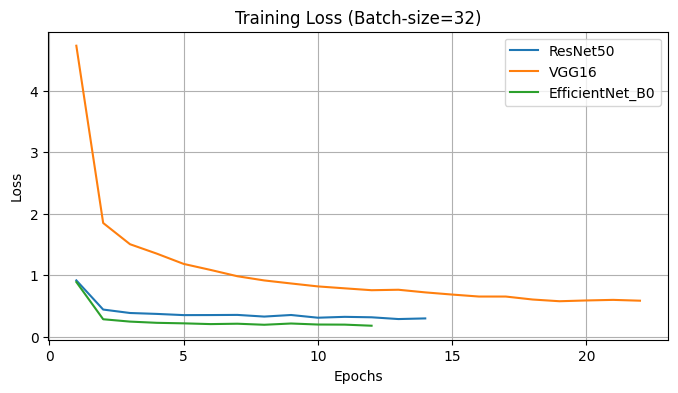

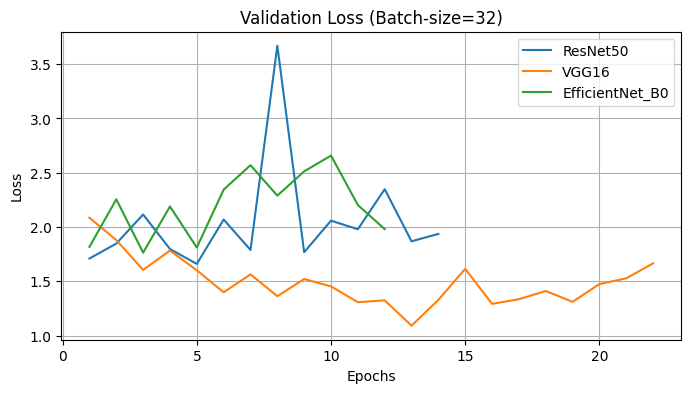

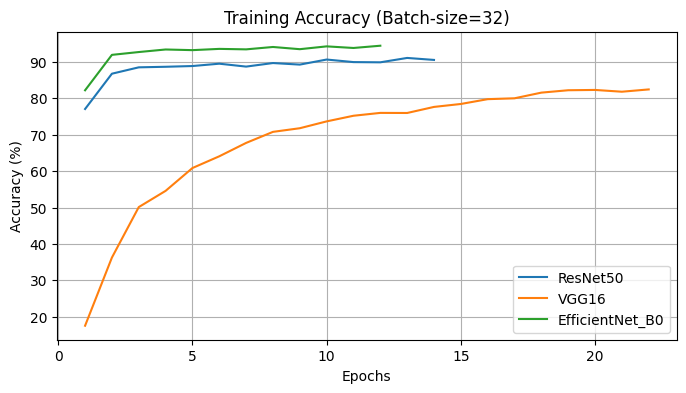

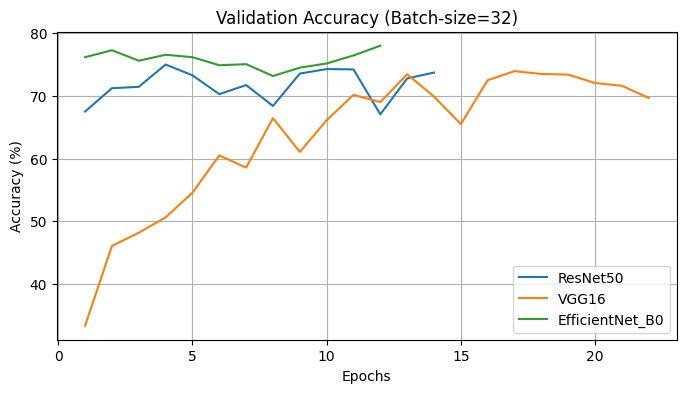

In [21]:
import matplotlib.pyplot as plt
modelname = ['ResNet50', 'VGG16', 'EfficientNet_B0']
# Plot training loss
plt.figure(figsize=(8,4))
for i in range(3):
  plt.plot(range(1, len(val_losses[i])+1), train_losses[i], label=modelname[i])
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss (Batch-size=32)')
plt.legend()
plt.show()

#Plot validation loss
plt.figure(figsize=(8,4))
for i in range(3):
  plt.plot(range(1, len(val_losses[i])+1), val_losses[i], label=modelname[i])
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss (Batch-size=32)')
plt.legend()
plt.show()

#Plot training accuracy
plt.figure(figsize=(8,4))
for i in range(3):
  plt.plot(range(1, len(val_losses[i])+1), train_accuracies[i], label=modelname[i])
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy (Batch-size=32)')
plt.legend()
plt.show()

#Plot validation accuracy
plt.figure(figsize=(8,4))
for i in range(3):
  plt.plot(range(1, len(val_losses[i])+1), val_accuracies[i], label=modelname[i])
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy (Batch-size=32)')
plt.legend()
plt.show()

In [ ]:
# Imageprint Function

import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Function to unnormalize and visualize a batch of images
def imshow(img, mean, std):
    # Unnormalize the image
    img = img * std[:, None, None] + mean[:, None, None]  
    img = np.clip(img, 0, 1)  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off') 
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Define mean and std
mean = torch.tensor([0.485, 0.456, 0.406])  
std = torch.tensor([0.229, 0.224, 0.225])   

# Reverse the label mapping
org_labels = {idx: label for label, idx in train_dataset.label_mapping.items()}

# Loop to display 4 images at a time
batch_size = 2
for i in range(0, len(images), batch_size):
    # Select a batch of 4 images and labels

    image_batch = images[i:i+batch_size]
    label_batch = labels[i:i+batch_size]

    # Show the images in the batch
    imshow(torchvision.utils.make_grid(image_batch), mean, std)

    # Print the labels for the current batch of images
    print('Labels: ', ' '.join(f'{org_labels[label_batch[j].item()]}' for j in range(len(label_batch))))